# Embedding

In [1]:
from sentence_transformers import SentenceTransformer
import polars as pl

In [2]:
df = pl.read_csv("../../data/processed/final/child/validated_data_airline_reviews_2_child_good.csv")
model = SentenceTransformer("all-MiniLM-L6-v2")  # léger et performant
embeddings = model.encode(df["review"].to_list(), show_progress_bar=True, normalize_embeddings=True)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

# Kmeans

In [3]:
from sklearn.cluster import KMeans
import polars as pl

# Nombre de clusters à tester
k = 2  # tu peux ajuster après visualisation

# Clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Ajouter les labels au DataFrame
df = df.with_columns(pl.Series("cluster", cluster_labels))


# 2D Visualization 

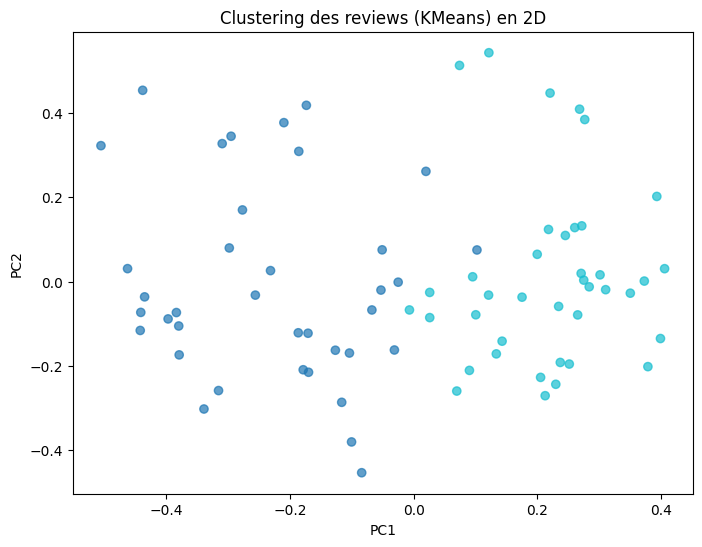

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Réduction en 2D
reduced = PCA(n_components=2).fit_transform(embeddings)

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=cluster_labels, cmap="tab10", alpha=0.7)
plt.title("Clustering des reviews (KMeans) en 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


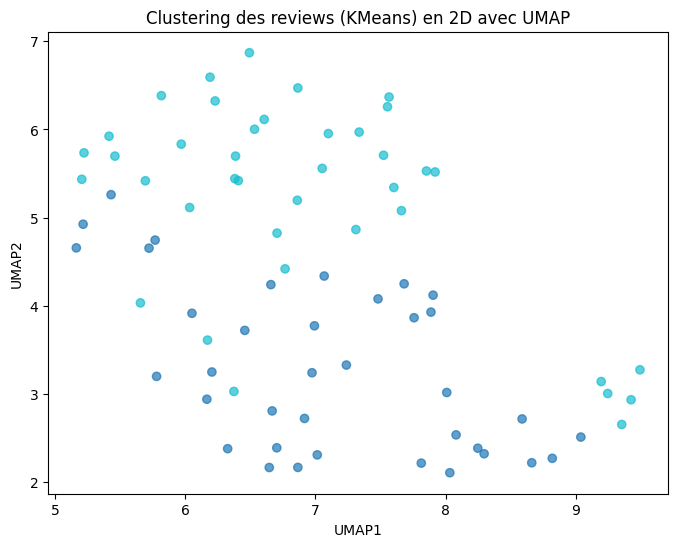

In [5]:
import umap
import matplotlib.pyplot as plt

# --- 1. Réduction en 2D des embeddings avec UMAP ---
reducer = umap.UMAP(n_components=2, random_state=42)
reduced = reducer.fit_transform(embeddings)

# --- 2. Scatter plot selon les clusters KMeans ---
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=cluster_labels, cmap="tab10", alpha=0.7)
plt.title("Clustering des reviews (KMeans) en 2D avec UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()


## Interpretation

Using natural language reviews to interpret the content of clusters won't work. This is because we chose to count word occurrences for interpretation. Stop words will inevitably be the most frequent.

In [6]:
from collections import Counter

for c in sorted(df["cluster"].unique()):
    texts = df.filter(pl.col("cluster") == c)["review"].to_list()
    words = " ".join(texts).split()
    top_words = Counter(words).most_common(20)
    print(f"\nCluster {c} — mots les plus fréquents : {top_words}")



Cluster 0 — mots les plus fréquents : [('and', 163), ('the', 157), ('was', 118), ('to', 118), ('a', 78), ('I', 69), ('with', 69), ('The', 50), ('in', 47), ('on', 47), ('were', 45), ('of', 45), ('for', 42), ('flight', 40), ('very', 35), ('not', 34), ('is', 33), ('as', 27), ('are', 26), ('my', 25)]

Cluster 1 — mots les plus fréquents : [('the', 418), ('to', 397), ('and', 300), ('I', 210), ('a', 190), ('was', 186), ('with', 132), ('for', 131), ('in', 129), ('of', 120), ('we', 118), ('my', 115), ('they', 107), ('were', 88), ('that', 85), ('on', 80), ('at', 78), ('not', 75), ('flight', 74), ('have', 67)]


That's why it's essential to retrieve clean reviews for interpretation.

In [7]:
import polars as pl

df_final = pl.read_csv("../../data/processed/final/child/validated_data_hotel_reviews_1_child_good.csv")
df_kw = pl.read_csv("../../data/processed/Bazarre/key_words_data_hotel_reviews_1.csv")

In [8]:
df_merged = df_final.join(
    df_kw,
    left_on="id",
    right_on="id",
    how="left"
)

In [9]:
model = SentenceTransformer("all-MiniLM-L6-v2")  # léger et performant
embeddings = model.encode(df_merged["review"].to_list(), show_progress_bar=True, normalize_embeddings=True)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
from sklearn.cluster import KMeans
import polars as pl

# Nombre de clusters à tester
k = 2  # tu peux ajuster après visualisation

# Clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Ajouter les labels au DataFrame
df_merged = df_merged.with_columns(pl.Series("cluster", cluster_labels))


In [11]:
from collections import Counter

for c in sorted(df_merged["cluster"].unique()):
    texts = df_merged.filter(pl.col("cluster") == c)["review_right"].to_list()
    words = " ".join(texts).split()
    top_words = Counter(words).most_common(20)
    print(f"\nCluster {c} — mots les plus fréquents : {top_words}")



Cluster 0 — mots les plus fréquents : [('was', 134), ('we', 77), ('room', 58), ('i', 54), ('were', 51), ('hotel', 50), ('pool', 49), ('is', 47), ('great', 42), ('had', 33), ('staff', 31), ('kids', 30), ('they', 23), ('stay', 23), ('clean', 23), ('you', 23), ('friendly', 22), ('not', 19), ('family', 19), ('nice', 18)]

Cluster 1 — mots les plus fréquents : [('was', 69), ('we', 54), ('family', 29), ('were', 27), ('i', 25), ('hotel', 23), ('had', 21), ('room', 20), ('stayed', 19), ('is', 19), ('two', 19), ('great', 15), ('clean', 14), ('staff', 14), ('rooms', 12), ('kids', 12), ('location', 12), ('us', 12), ('five', 12), ('stay', 12)]


## Visualization of category

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- 1. Réduction en 2D des embeddings ---
reduced = PCA(n_components=2).fit_transform(embeddings)

# --- 2. Préparer les couleurs selon les catégories ---
categories = df["category"].to_list()
unique_categories = list(set(categories))
color_map = {cat: i for i, cat in enumerate(unique_categories)}
colors = [color_map[cat] for cat in categories]

# --- 3. Scatter plot ---
plt.figure(figsize=(10,7))
scatter = plt.scatter(reduced[:,0], reduced[:,1], c=colors, cmap="tab10", alpha=0.4)
plt.title("Visualisation des reviews en 2D selon la catégorie")
plt.xlabel("PC1")
plt.ylabel("PC2")

# --- 4. Légende avec les catégories ---
handles, _ = scatter.legend_elements()
plt.legend(handles, unique_categories, title="Category")
plt.show()


ColumnNotFoundError: "category" not found

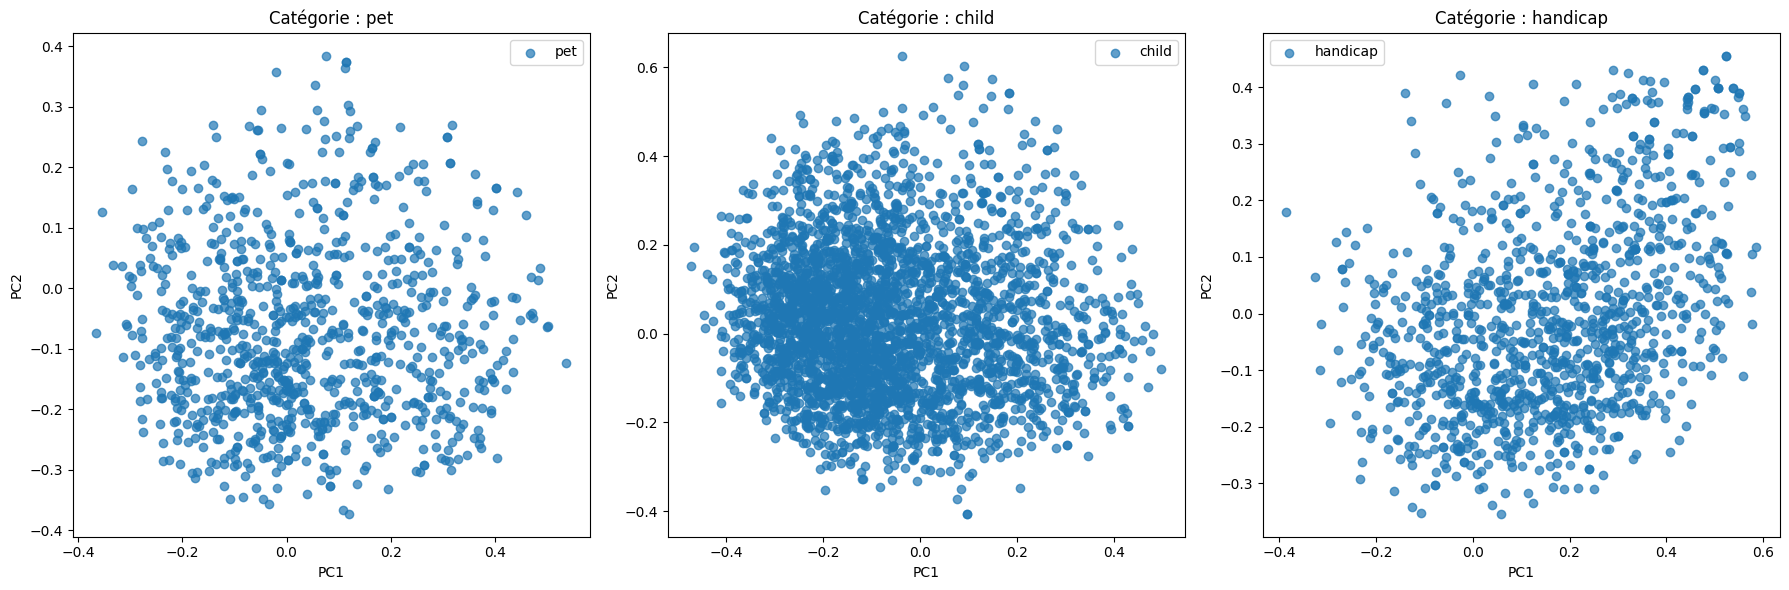

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# --- 1. Réduction en 2D des embeddings ---
reduced = PCA(n_components=2).fit_transform(embeddings)

# --- 2. DataFrame temporaire pour faciliter le filtrage ---
df_plot = pd.DataFrame({
    "PC1": reduced[:,0],
    "PC2": reduced[:,1],
    "category": df["category"].to_list()
})

# --- 3. Liste des catégories à afficher ---
categories_to_plot = ["pet", "child", "handicap"]

# --- 4. Création de la figure avec 3 subplots côte à côte ---
fig, axes = plt.subplots(1, 3, figsize=(18,6))  # 1 ligne, 3 colonnes

for ax, cat in zip(axes, categories_to_plot):
    df_cat = df_plot[df_plot["category"] == cat]
    ax.scatter(df_cat["PC1"], df_cat["PC2"], alpha=0.7, label=cat)
    ax.set_title(f"Catégorie : {cat}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend()

plt.tight_layout()
plt.show()


# Test avec UMAP

c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


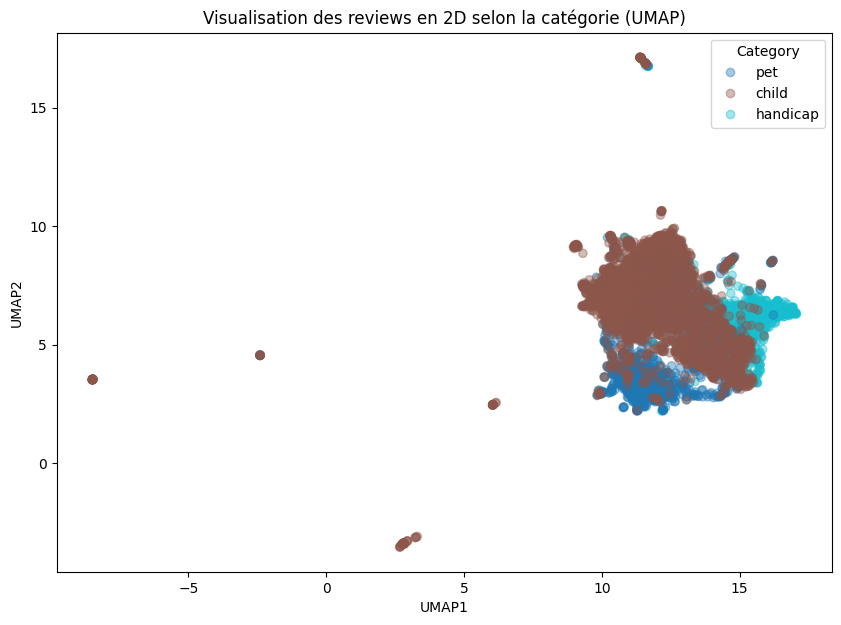

In [ ]:
import umap
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Réduction en 2D des embeddings avec UMAP ---
reducer = umap.UMAP(n_components=2, random_state=42)
reduced = reducer.fit_transform(embeddings)

# --- 2. Préparer le DataFrame pour faciliter le plot ---
df_plot = pd.DataFrame({
    "UMAP1": reduced[:,0],
    "UMAP2": reduced[:,1],
    "category": df["category"].to_list()
})

# --- 3. Préparer les couleurs selon les catégories ---
categories = df_plot["category"].to_list()
unique_categories = list(set(categories))
color_map = {cat: i for i, cat in enumerate(unique_categories)}
colors = [color_map[cat] for cat in categories]

# --- 4. Scatter plot ---
plt.figure(figsize=(10,7))
scatter = plt.scatter(df_plot["UMAP1"], df_plot["UMAP2"], c=colors, cmap="tab10", alpha=0.4)
plt.title("Visualisation des reviews en 2D selon la catégorie (UMAP)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

# --- 5. Légende avec les catégories ---
handles, _ = scatter.legend_elements()
plt.legend(handles, unique_categories, title="Category")
plt.show()


c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


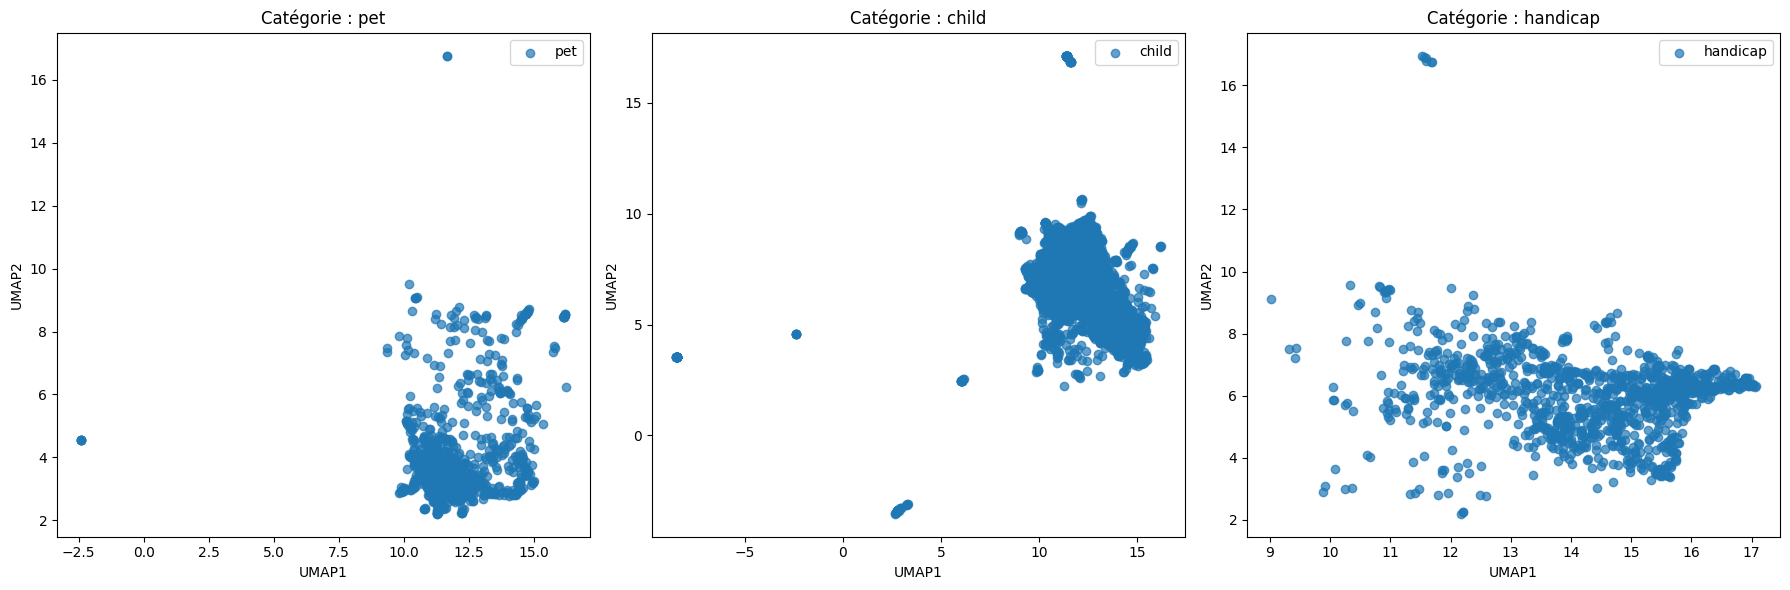

In [ ]:
import umap
import matplotlib.pyplot as plt
import pandas as pd

# Réduction en 2D avec UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

df_plot = pd.DataFrame({
    "UMAP1": embedding_2d[:,0],
    "UMAP2": embedding_2d[:,1],
    "category": df["category"].to_list()
})

# Visualisation par catégorie
categories_to_plot = ["pet", "child", "handicap"]
fig, axes = plt.subplots(1, 3, figsize=(18,6))

for ax, cat in zip(axes, categories_to_plot):
    df_cat = df_plot[df_plot["category"] == cat]
    ax.scatter(df_cat["UMAP1"], df_cat["UMAP2"], alpha=0.7, label=cat)
    ax.set_title(f"Catégorie : {cat}")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.legend()

plt.tight_layout()
plt.show()
